<a href="https://colab.research.google.com/github/danimonz/Senior-Thesis/blob/main/Flight_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

sns.set()

In [3]:
#load dataset located in google drive
#We have a training data set and a test dataset
train_data = pd.read_excel("/content/drive/MyDrive/Flight Data/Data_Train.xlsx")
#sets the width of the displayed dataset to fit the notebook
pd.set_option('display.max_columns', None)
#tells us the names of the columns and the data types
train_data.info()
#provides first five entries in our training dataset
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
#check if we have any missing values
train_data.isnull().sum()
#we will drop the missing values and recheck if we have missing values 
train_data.dropna(inplace = True)
train_data.isnull().sum() # we can see we have no missing values, all column sums are 0

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

Continuous Variables
- Date of Journey, Arrival Time, and Departure Time

In [5]:
#we will now convert our features into appropriate values

# We are splitting Date_of_Journey into seperate day and month columns. All data comes form year 2019
train_data["journey_day"] = pd.to_datetime(train_data["Date_of_Journey"], format="%d/%m/%Y").dt.day
train_data["journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
# After we seperate the data from the Date_of_Journey column, we can drop that column
train_data.drop(columns=["Date_of_Journey"], inplace = True)
train_data.head()

#We will now repeat this for Departure Time, Arrival Time, and Duration

# We are splitting Dep_Time into hour and minute columns
train_data["dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour
train_data["dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute
# We will now drop the Date_of_Journey column
train_data.drop(columns=["Dep_Time"], inplace = True)

# We are splitting the Arrival_Time into seperate hour and minute columns
train_data["arrival_hour"] = pd.to_datetime(train_data["Arrival_Time"]).dt.hour
train_data["arrival_min"] = pd.to_datetime(train_data["Arrival_Time"]).dt.minute
# After splitting the data, we drop the Arrival_time column
train_data.drop(columns=["Arrival_Time"], inplace = True)

In [6]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [7]:
# Assign the Duration column to a list for looping through
duration = train_data["Duration"].tolist()

# Loop through each duration value to ensure it includes both hours and minutes: 'xh ym'
for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or minute
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

# Extract the hours and minutes from the duration and append them to separate lists
duration_hours = [int(d.split(sep="h")[0]) for d in duration]
duration_minutes = [int(d.split(sep="m")[0].split()[-1]) for d in duration]

# Add the duration_hours and duration_minutes lists to the dataset
train_data["Duration_hours"] = duration_hours
train_data["Duration_minutes"] = duration_minutes

# Drop the Duration column from the dataset
train_data.drop(columns=["Duration"], inplace=True)

train_data.head()


,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


Categorical Variables
- Airline, Source, Destination, Route, Total Stops, and Additional Info

In [8]:
# Airline Value Counts
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [9]:
# As Airline is nominal categorical data, we will perform one-hot encoding
# Only keep the airlines in the specified list, and group the rest into 'Other'
airlines_to_keep = ['Jet Airways', 'IndiGo', 'Air India', 'SpiceJet', 'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia']
Airline = train_data[["Airline"]]
Airline.loc[~Airline['Airline'].isin(airlines_to_keep), 'Airline'] = 'Other'
Airline_encoded = pd.get_dummies(Airline, prefix='Airline')

# Print the value counts of each airline
print(Airline_encoded.sum())
#Print one-hot encoding
Airline_encoded.head()

Airline_Air Asia              319
Airline_Air India            1751
Airline_GoAir                 194
Airline_IndiGo               2053
Airline_Jet Airways          3849
Airline_Multiple carriers    1196
Airline_Other                  23
Airline_SpiceJet              818
Airline_Vistara               479
dtype: int64


<ipython-input-9-61c8948f8445>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Airline.loc[~Airline['Airline'].isin(airlines_to_keep), 'Airline'] = 'Other'


,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara
0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [10]:
# Print the value counts of each source
print(train_data["Source"].value_counts())

# As Source is nominal categorical data, we will perform one-hot encoding
Source = train_data[["Source"]]
Source_encoded = pd.get_dummies(Source, drop_first=True)

# Print the first few rows of the encoded DataFrame
print(Source_encoded.head())

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64
   Source_Chennai  Source_Delhi  Source_Kolkata  Source_Mumbai
0               0             0               0              0
1               0             0               1              0
2               0             1               0              0
3               0             0               1              0
4               0             0               0              0


In [11]:
# Print the value counts of each destination
print(train_data["Destination"].value_counts())

# Rename "New Delhi" values to "Delhi"
Destination = train_data[["Destination"]]
Destination.loc[Destination['Destination'] == 'New Delhi', 'Destination'] = 'Delhi'

# As Destination is nominal categorical data, we will perform one-hot encoding
Destination_encoded = pd.get_dummies(Destination, drop_first=True)

# Print the first few rows of the encoded DataFrame
print(Destination_encoded.head())
print(len(Destination_encoded))

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64
   Destination_Cochin  Destination_Delhi  Destination_Hyderabad  \
0                   0                  1                      0   
1                   0                  0                      0   
2                   1                  0                      0   
3                   0                  0                      0   
4                   0                  1                      0   

   Destination_Kolkata  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
10682


<ipython-input-11-020e409c0993>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Destination.loc[Destination['Destination'] == 'New Delhi', 'Destination'] = 'Delhi'


In [12]:
# Drop the "Route" and "Additional_Info" columns
train_data.drop(columns=["Route", "Additional_Info"], inplace=True)

# Print the value counts of each unique value in the "Total_Stops" column
print(train_data["Total_Stops"].value_counts())

# Assign corresponding numeric values to each categorical level in "Total_Stops"
train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace=True)

# Print the first few rows of the modified DataFrame
print(train_data.head())

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64
       Airline    Source Destination  Total_Stops  Price  journey_day  \
0       IndiGo  Banglore   New Delhi            0   3897           24   
1    Air India   Kolkata    Banglore            2   7662            1   
2  Jet Airways     Delhi      Cochin            2  13882            9   
3       IndiGo   Kolkata    Banglore            1   6218           12   
4       IndiGo  Banglore   New Delhi            1  13302            1   

   journey_month  dep_hour  dep_min  arrival_hour  arrival_min  \
0              3        22       20             1           10   
1              5         5       50            13           15   
2              6         9       25             4           25   
3              5        18        5            23           30   
4              3        16       50            21           35   

   Duration_hours  Duration_minutes  
0        

In [13]:
train_data = pd.concat([train_data, Airline_encoded, Source_encoded, Destination_encoded], axis = 1) # axis = 1 signifies column
train_data.drop(columns=["Airline", "Source", "Destination"], inplace = True)
train_data.info

<bound method DataFrame.info of        Total_Stops  Price  journey_day  journey_month  dep_hour  dep_min  \
0                0   3897           24              3        22       20   
1                2   7662            1              5         5       50   
2                2  13882            9              6         9       25   
3                1   6218           12              5        18        5   
4                1  13302            1              3        16       50   
...            ...    ...          ...            ...       ...      ...   
10678            0   4107            9              4        19       55   
10679            0   4145           27              4        20       45   
10680            0   7229           27              4         8       20   
10681            0  12648            1              3        11       30   
10682            2  11753            9              5        10       55   

       arrival_hour  arrival_min  Duration_hours  Durat

Feature Selection

We have 25 features available for use in our model. We will now rank the features in order of importance to avoid multicollinearality. 

(10682, 25) (10682,)
[0.23008341 0.14982448 0.05881729 0.02457242 0.02436255 0.02798139
 0.01910052 0.12769976 0.01773565 0.0117248  0.00184262 0.0253433
 0.14053834 0.0178518  0.03072128 0.00565124 0.00457449 0.0007742
 0.01189719 0.00494995 0.00767382 0.00937897 0.03586372 0.01029949
 0.00073733]


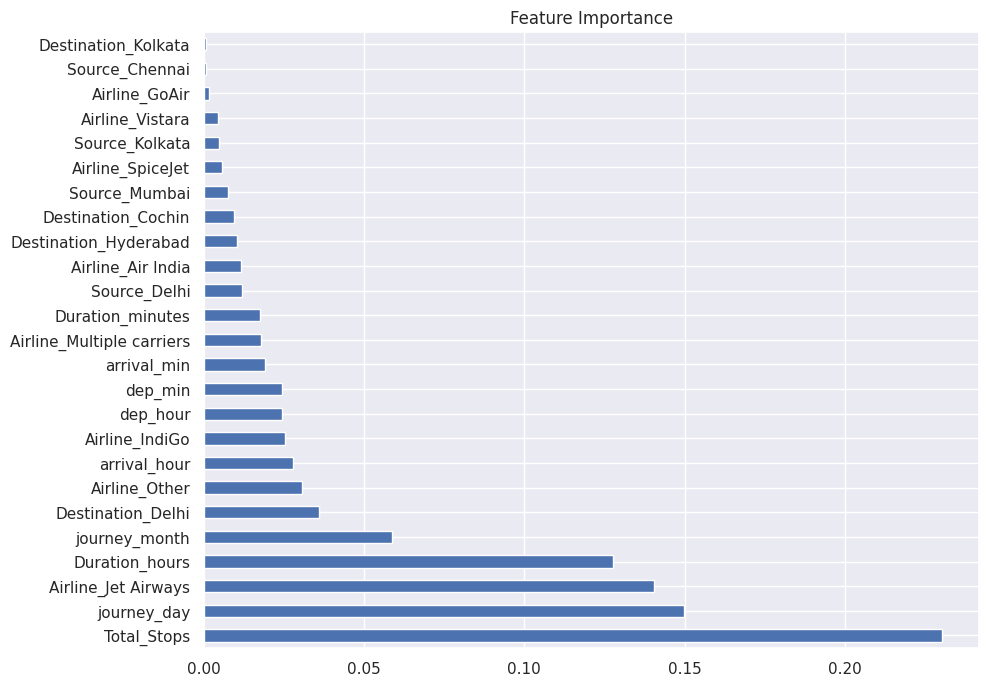

In [14]:
X = train_data.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_minutes', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y = train_data.iloc[:, 1]
print(X.shape, y.shape)

# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)
print(selection.feature_importances_)

# Plot graph of feature importances for better visualization
plt.figure(figsize = (10,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [15]:

# Drop unwanted features
X = train_data.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_minutes', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
#Dropped 'Source_Kolkata',  'Airline_Air India',
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Total_Stops                10682 non-null  int64
 1   journey_day                10682 non-null  int64
 2   journey_month              10682 non-null  int64
 3   dep_hour                   10682 non-null  int64
 4   dep_min                    10682 non-null  int64
 5   arrival_hour               10682 non-null  int64
 6   arrival_min                10682 non-null  int64
 7   Duration_hours             10682 non-null  int64
 8   Duration_minutes           10682 non-null  int64
 9   Airline_GoAir              10682 non-null  uint8
 10  Airline_IndiGo             10682 non-null  uint8
 11  Airline_Jet Airways        10682 non-null  uint8
 12  Airline_Multiple carriers  10682 non-null  uint8
 13  Airline_Other              10682 non-null  uint8
 14  Airline_SpiceJet      

In [16]:
# Checking for multicollinearity using the Variance Inflation Factor (VIF) method
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    # Calculating the VIF for each variable
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Compute VIF on X
vif = calculate_vif(X)
print(vif)

/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                    variables        VIF
0                 Total_Stops   7.172826
1                 journey_day   3.414811
2               journey_month  11.988524
3                    dep_hour   5.461772
4                     dep_min   2.811278
5                arrival_hour   4.526061
6                 arrival_min   3.305768
7              Duration_hours   6.047578
8            Duration_minutes   4.106614
9               Airline_GoAir   1.141582
10             Airline_IndiGo   2.148845
11        Airline_Jet Airways   2.749514
12  Airline_Multiple carriers   1.815049
13              Airline_Other   1.012040
14           Airline_SpiceJet   1.542892
15            Airline_Vistara   1.277660
16             Source_Chennai        inf
17               Source_Delhi        inf
18              Source_Mumbai        inf
19         Destination_Cochin        inf
20          Destination_Delhi   1.843796
21      Destination_Hyderabad        inf
22        Destination_Kolkata        inf


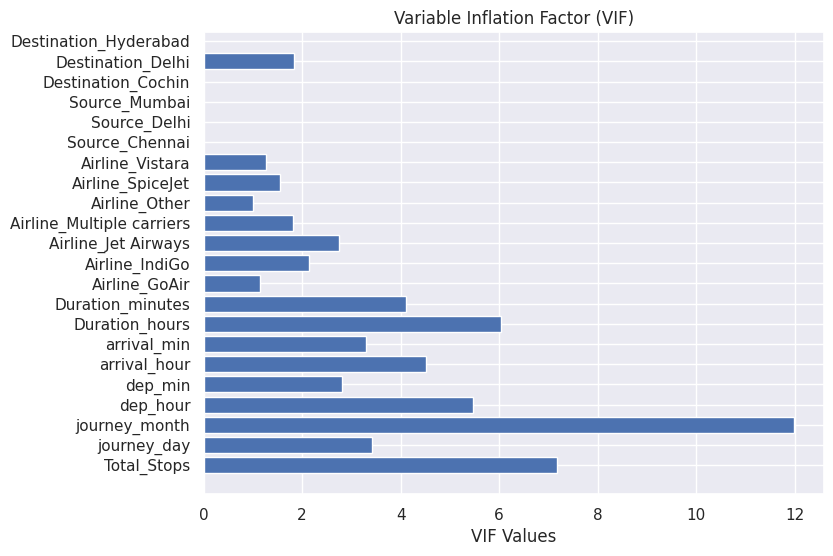

In [17]:
variables = ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour', 'dep_min', 'arrival_hour',
             'arrival_min', 'Duration_hours', 'Duration_minutes', 'Airline_GoAir', 'Airline_IndiGo',
             'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other', 'Airline_SpiceJet',
             'Airline_Vistara', 'Source_Chennai', 'Source_Delhi', 'Source_Mumbai', 'Destination_Cochin',
             'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']
vif = [7.172826, 3.414811, 11.988524, 5.461772, 2.811278, 4.526061, 3.305768, 6.047578,
       4.106614, 1.141582, 2.148845, 2.749514, 1.815049, 1.012040, 1.542892, 1.277660,
       np.inf, np.inf, np.inf, np.inf, 1.843796, np.inf, np.inf]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(variables, vif)
ax.set_xlabel('VIF Values')
ax.set_title('Variable Inflation Factor (VIF)')

plt.show()

Model performance on training set: 95.3
Model performance on test set: 78.93


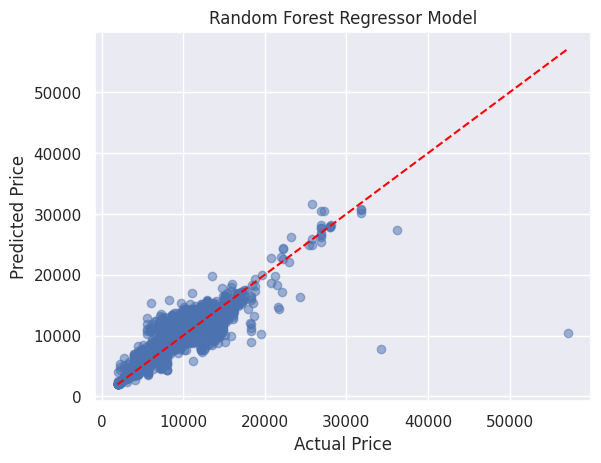

MAE: 1198.6518189481708
MSE: 4542178.899936378
RMSE: 2131.2388181375586
Normalized RMSE: 0.04
Max Price: 79512
Min Price: 1759


In [18]:
# Split the data into training and test sets with an 80:20 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the random forest regression model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Evaluate the model's performance on the training and test sets
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Model performance on training set:', round(train_score*100, 2))
print('Model performance on test set:', round(test_score*100, 2))

# Plot the model's performance on the test set
y_pred = rf_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest Regressor Model")

x = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()))
plt.plot(x, x, color='red', linestyle='--')

plt.show()

# Compute the model's error metrics
from sklearn import metrics
import numpy as np
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
nrmse = round(rmse/(max(y_test)-min(y_test)), 2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('Normalized RMSE:', nrmse)
print('Max Price:', max(y))
print('Min Price:', min(y))

# Save the trained model to a pickle file
import pickle
with open('flight_price_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

Model Performance on Training Set: 56.94
Model Performance on Test Set: 56.86


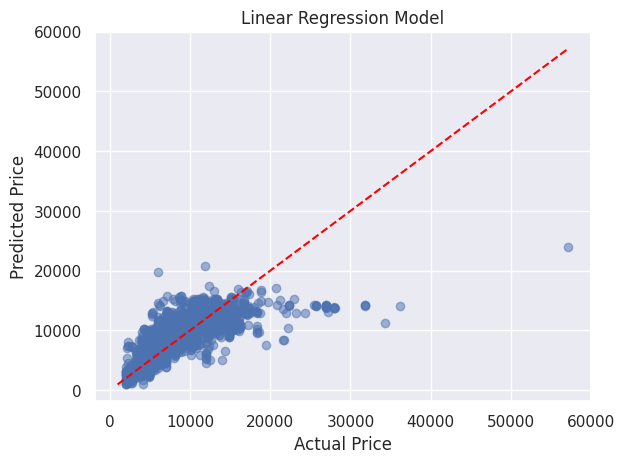

MAE: 2042.6839398700142
MSE: 9302909.727005692
RMSE: 3050.0671676220004
Normalized RMSE: 0.06
Max Price: 79512
Min Price: 1759


In [21]:
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
print('Model Performance on Training Set:', round(lr_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(lr_reg.score(X_test, y_test)*100,2))
y_pred = lr_reg.predict(X_test)

# Plot the model's performance on the test set
y_pred = lr_reg.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression Model")

x = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()))
plt.plot(x, x, color='red', linestyle='--')


plt.show()

# Compute the model's error metrics
from sklearn import metrics
import numpy as np
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
nrmse = round(rmse/(max(y_test)-min(y_test)), 2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('Normalized RMSE:', nrmse)
print('Max Price:', max(y))
print('Min Price:', min(y))

(10682, 25) (10682,)
[ 3.14071069e+03 -8.24162320e+01 -6.05203527e+02  2.43626985e+01
  3.75508426e-01 -1.42360235e+01 -3.52776950e-01 -3.49778055e-01
 -3.45789352e+00  1.61741095e+03 -8.80876728e+00  3.18508208e+02
  4.41575732e+03  3.85007993e+03  1.49872518e+04 -1.96373289e+02
  2.14780858e+03  1.64001631e+02  3.12482386e+00  7.92984790e+01
 -7.17835591e+02  3.12482386e+00  4.71410657e+02 -7.17835591e+02
  1.64001631e+02]


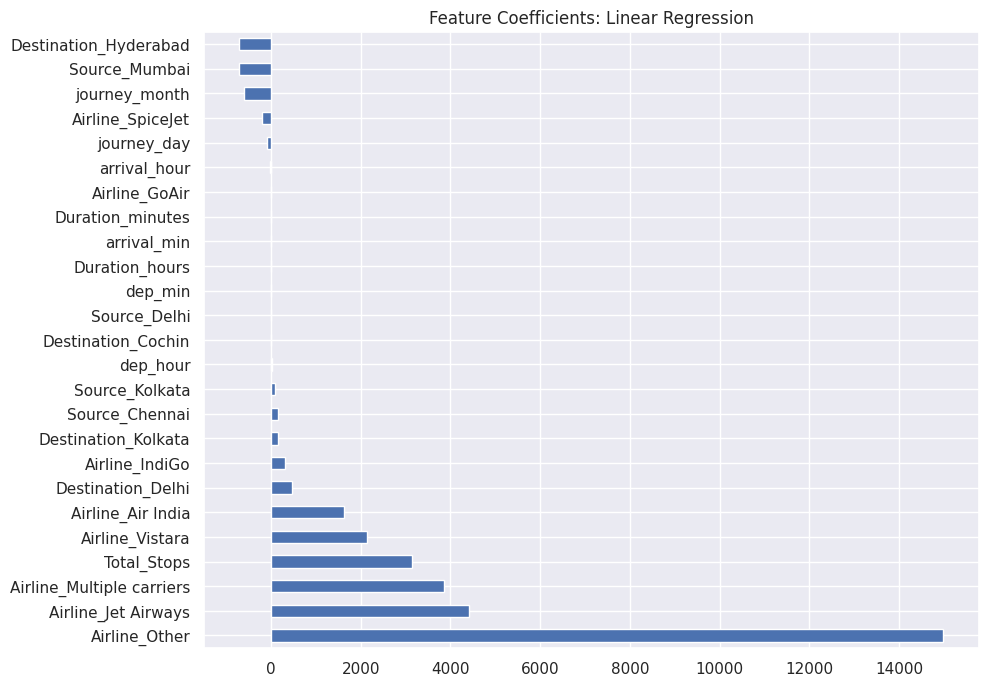

In [20]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Select features and target variable
X = train_data.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',       'Duration_minutes', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y = train_data.iloc[:, 1]
print(X.shape, y.shape)

# Fit linear regression model
selection = LinearRegression()
selection.fit(X, y)

# Get feature coefficients
print(selection.coef_)

# Plot graph of feature coefficients for better visualization
plt.figure(figsize = (10,8))
feat_coeffs = pd.Series(selection.coef_, index=X.columns)
feat_coeffs.nlargest(25).plot(kind='barh')
plt.title("Feature Coefficients: Linear Regression")
plt.show()
